In [1]:
# import library
import pickle, os
import pandas as pd
import numpy as np
import tqdm.notebook as tqdm
import copy
from scipy.stats.mstats import winsorize
from statsmodels.formula.api import ols

os.chdir('C:\\Users\\lyoo9\\_Moggle-Labs')
# # Data Download
with open('FS_손익계산서보정본', 'rb') as f:
    data = pickle.load(f)

with open('Final_FS_ind', 'rb') as f:
    ind = pickle.load(f)

# 특정 자산만 뽑아서 csv로 정리하기
def get_item(concept_id):
    item = []
    item_ind = []
    # check id's address
    id_address = None
    for i in range(len(data)):
        for j in range(3):
            try:
                if concept_id in data[i][j].iloc[:,0].values:
                    id_address = j
            except AttributeError:
                pass
        if id_address != None:
            break
            
    for i in range(len(data)):
        if type(data[i][id_address]) == type(data[0][id_address]):
            item.append(data[i][id_address][data[i][id_address][data[i][id_address].columns[0]] == concept_id].iloc[:1])
            if len(data[i][id_address][data[i][id_address][data[i][id_address].columns[0]] == concept_id]) > 0:
                item_ind.append(ind[i])
    df_item = pd.concat(item)
    date = list(filter(lambda x: x[1] == ('연결재무제표',), df_item.columns))
    if id_address ==0:
        date_clean = list(map(lambda x: x[0], df_item[date].columns))
        df_item[date].columns = date_clean
        df_item2 = df_item[date]
        df_item2.columns = date_clean
        date_shifted = list(map(lambda x: shift_q(x), date_clean))
        df_item3 = df_item2
        df_item3.columns = date_shifted
        df_item4 = df_item3.groupby(level=0, axis=1).last()
        df_item3 = df_item4
        date_shifted2 = list(map(lambda x: shift_d(x), df_item4.columns))
        df_item3.columns = date_shifted2
        df_item5 = df_item3.groupby(level=0, axis=1).last()
        corp_code = list(map(lambda x:x[2], item_ind))
        df_item5['corp_code'] = corp_code
        df_item5 = df_item5.set_index('corp_code')
    else:
        date_clean = list(map(lambda x: x[0], df_item[date].columns))
        df_item[date].columns = date_clean
        df_item2 = df_item[date]
        df_item2.columns = date_clean
        date_shifted = list(map(lambda x: shift_flow_date(x), date_clean))
        df_item2.columns = date_shifted
        df_item3 = df_item2.groupby(level=0, axis=1).last()
        corp_code = list(map(lambda x:x[2], item_ind))
        df_item3['corp_code'] = corp_code
        df_item3 = df_item3.set_index('corp_code')
        df_item5 = df_item3
    return df_item5

def shift_q(date):
    if date[4:6]=='01' or date[4:6]=='02':
        date = date[:4] + '0331'
    elif date[4:6]=='04' or date[4:6]=='05':
        date = date[:4] + '0630'
    elif date[4:6]=='07' or date[4:6]=='08':
        date = date[:4] + '0930'
    elif date[4:6]=='10' or date[4:6]=='11':
        date = date[:4] + '1231'
    return date

def shift_d(date):
    # 케이스 두개 밖에 안되니까 그냥 수동으로 따져주자.
    if date[6:]=='01':
        date = date[:6] + '31'
    elif date[6:]=='29':
        date = date[:6] + '30'
    return date

def shift_flow_date(date):
    # 우선은 연간 데이터만 활용하도록 만들어놓아도 될 듯? 나중에 분기별로 뽑을 수 있는 옵션을 추가해야 할 것 같다.
    if date[4:6]=='01' and date[-4:-2]=='12':
        date = date[-8:-2] + '31'
    else:
        date = None
    return date

def get_item_on_date(item, date):
    return get_item(item)[date]

def get_item_for_period(item, date_from, date_to, term = 'Y'):
    # term은 Y, H, Q의 세 가지 옵션으로, 연도별, 반기별, 분기별 데이터를 얻어올 수 있도록 하는 옵션이다.
    data = []
    item_data = get_item(item)
    if term == 'Y':
        num = int(date_to[:4]) - int(date_from[:4]) +1
        date_working = date_from
        for i in range(num):
            data.append(item_data[date_working])
            date_working = date_working[:2] + str(int(date_working[2:4]) + 1) + date_working[4:]
            
    elif term == 'H':
        num = int((int(date_to[:4]) - int(date_from[:4])) * 2 + (int(date_to[4:6]) - int(date_from[4:6]))/6 + 1)
        date_working = date_from
        for i in range(num):
            try:
                data.append(item_data[date_working])
            except:
                try:
                    date_working = date_working[:6] + str(61 - int(date_working[6:]))
                    data.append(item_data[date_working])
                except KeyError:
                    print('해당 날짜의 데이터가 없습니다:', date_working)
            if int(date_working[4:6])+6 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0'+ str(int(date_working[4:6])-6)+'31'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 6).zfill(2) + '31'
                
    else:
        num = int((int(date_to[:4]) - int(date_from[:4])) * 4 + (int(date_to[4:6]) - int(date_from[4:6]))/3 + 1)
        date_working = date_from
        for i in range(num):
            try:
                data.append(item_data[date_working])
            except:
                try:
                    date_working = date_working[:6] + str(61 - int(date_working[6:]))
                    data.append(item_data[date_working])
                except KeyError:
                    print('해당 날짜의 데이터가 없습니다:', date_working)
            if int(date_working[4:6])+3 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0331'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 3).zfill(2) + '31'
                
    data = pd.concat(data, axis = 1)
    return data

os.chdir('C:\\Users\\lyoo9\\_System Trading\\Backend\\KRX_price')
def get_market_data_on_date(date, print_error = True):
    # 에러 메시지를 출력하고 싶지 않으면 print_error를 False로 설정
    try:
        data = pd.read_csv(date[2:4] + '_' + str(int(date[4:6])) + '_' + str(int(date[6:8])) + '.csv', encoding = 'cp949')
        data['종목코드'] = data['종목코드'].map(lambda x:str(x).zfill(6) if x != None else None)
        if data.isna()['종가'].sum() == len(data):
            raise FileNotFoundError
    except FileNotFoundError:
        if print_error:
            print('해당 날짜의 데이터가 존재하지 않습니다:', date)
        data = None
    return data

def get_market_cap_on_date(date, get_code = False):
    if get_code:
        data = get_market_data_on_date(date)[['종목코드','시장구분','시가총액']].set_index('종목코드')
        data.columns = [['시장구분','Market_Cap']]
    else:
        data = get_market_data_on_date(date)[['종목코드','시가총액']].set_index('종목코드')
        data.columns = [['Market_Cap']]
    data.index.rename('corp_code', inplace = True)
    return data

def last_market_date(date):
    # date의 기본형식은 'YYYYMM' : ex)'201212'. -> 'YYYYMMDD'도 가능하도록 코드 변경했음
    get_data = False
    day = 31
    while not get_data:
        if type(get_market_data_on_date(date[:6] + str(day), print_error = False)) != type(None):
            market_date = date[:6] + str(day)
            get_data = True
        else:
            day -=1
    return market_date

def find_next_market_date(date, today_opt = False):
    get_data = False
    if today_opt:
        market_date = pd.Timestamp(date)
    else:
        market_date = pd.Timestamp(date) + pd.Timedelta(days=1)
    while not get_data:
        if type(get_market_data_on_date(market_date.strftime('%Y%m%d'), print_error = False)) != type(None):
            get_data = True
        else:
            market_date += pd.Timedelta(days=1)
    
    return market_date.strftime('%Y%m%d')

def get_market_cap_for_period(date_from, date_to, term = 'Y', ind_match = True):
    # ind_match는 fundamental과 합치기 편하도록 실제 날짜가 아니라 월말 날짜를 표시하도록 하는 옵션
    data = []
    ind = []
    if term == 'Y':
        num = int(date_to[:4]) - int(date_from[:4]) +1
        date_working = date_from
        for i in range(num):
            data.append(get_market_cap_on_date(last_market_date(date_working), get_code = True))
            if ind_match:
                ind.append(date_working)
            else:
                ind.append(last_market_date(date_working))
            date_working = date_working[:2] + str(int(date_working[2:4]) + 1) + date_working[4:]
            
    elif term == 'H':
        num = int((int(date_to[:4]) - int(date_from[:4])) * 2 + (int(date_to[4:6]) - int(date_from[4:6]))/6 + 1)
        date_working = date_from
        for i in range(num):
            data.append(get_market_cap_on_date(last_market_date(date_working), get_code = True))
            if ind_match:
                ind.append(date_working)
            else:
                ind.append(last_market_date(date_working))
            if int(date_working[4:6])+6 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0'+ str(int(date_working[4:6])-6)+'31'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 6).zfill(2) + '31'
                
    else:
        num = int((int(date_to[:4]) - int(date_from[:4])) * 4 + (int(date_to[4:6]) - int(date_from[4:6]))/3 + 1)
        date_working = date_from
        for i in range(num):
            data.append(get_market_cap_on_date(last_market_date(date_working), get_code = True))
            if ind_match:
                ind.append(date_working)
            else:
                ind.append(last_market_date(date_working))
            if int(date_working[4:6])+3 > 12:
                date_working = date_working[:2] + str(int(date_working[2:4]) + 1) +'0331'
            else:
                date_working = date_working[:4] + str(int(date_working[4:6]) + 3).zfill(2) + '31'
    cap_data = [x.iloc[:,1] for x in data]
    cat_data = [x.iloc[:,0] for x in data]
    cap_data = pd.concat(cap_data, axis =1)
    cap_data.columns = ind
    cat_data = pd.concat(cat_data, axis =1)
    cat_data.columns = ind
    return cap_data, cat_data

def get_market_category(data):
    market_cat = []
    for i in range(len(data.columns)):
        market_cat.append(get_market_cap_on_date(last_market_date(data.columns[i]), get_code = True).iloc[:,0])
    market_cat = pd.concat(market_cat, axis=1)
    market_cat.columns = data.columns
    return market_cat

def get_breakpoint(data, breakpoint):
    absolute_point = []
    rank = data.rank(pct=True)
    for i in range(len(breakpoint)):
        absolute_point.append((data[rank < breakpoint[i]].max() + data[rank > breakpoint[i]].min())/2)
    return absolute_point

def get_mask(data, market_cat = None, market_bp = 'All', breakpoint: list = [0.5]):
    # data는 mask의 기준이 되는 baseline data
    # market_bp는 'ALL', 'KOSPI', 'KOSDAQ'으로, 기준이 되는 breakpoint의 market을 의미
    # breakpoint는 masking의 구분점으로, list안에 float이 담긴 형태를 받음
    breakpoint = np.sort(breakpoint)
    mask_list = []
    
    data_ind = data.index
    if type(market_cat) != type(None):
        market_cat = market_cat[market_cat.index.map(lambda x: x in data.index)]
        for i in range(len(data)):
            if data_ind[i] not in market_cat.index:
                market_cat.loc[data_ind[i]] = None
        market_cat = market_cat.reindex(index = data.index)
    for i in range(len(data.columns)):
        mask = data.iloc[:,i] * 0 +1
        mask_np = -np.ones(len(mask))
        #rank = data.iloc[:,i].rank(pct = True)
        if market_bp == 'All':
            absolute_point = get_breakpoint(data.iloc[:,i], breakpoint)
        if market_bp == 'KOSPI':
            absolute_point = get_breakpoint(data[market_cat.iloc[:,i]=='KOSPI'].iloc[:,i], breakpoint)
        if market_bp == 'KOSDAQ':
            absolute_point = get_breakpoint(data[market_cat.iloc[:,i]=='KOSDAQ'].iloc[:,i], breakpoint)
        for j in range(len(breakpoint)+1):
            if j < len(breakpoint):
                for k in range(len(mask)):
                    mask_np[k] = j if data.iloc[k,i] < absolute_point[j] and mask_np[k] == -1 else mask_np[k]
            else:
                for k in range(len(mask)):
                    mask_np[k] = j if data.iloc[k,i] > absolute_point[j-1] and mask_np[k] == -1 else mask_np[k]
        mask = mask * mask_np
        mask_list.append(mask)
    mask_df = pd.concat(mask_list, axis =1)
    return mask_df

def shift_date_quarter(data, num_of_quarters):
    # data의 date를 원하는 만큼 밀어줌.
    dates = data.columns
    years = [int(x[:4]) for x in dates]
    months = [int(x[4:6]) for x in dates]
    shifted_months = [x + num_of_quarters * 3 for x in months]
    shifted_years = [x + (shifted_months[i]-1) // 12 for i, x in enumerate(years)]
    shifted_months = [(x -1) % 12 +1 for x in shifted_months]
    dates = [str(shifted_years[i]) + str(shifted_months[i]).zfill(2)+ '30' if shifted_months[i] in [6, 9] else str(shifted_years[i]) + str(shifted_months[i]).zfill(2)+ '31' for i in np.arange(len(years))]
    data2 = copy.deepcopy(data)
    data2.columns = dates
    return data2
 
def get_factor_on_date_by_mask(mask, term = 'd', winsorize_limits = 0.01, weight = 'EW'):
    # @@@@@@@@@@@ option 추가해야할듯! : daily / weekly / monthly / quarterly 정도까지는 구현을 해놓아야할듯
    # monthly 계산할 때 첫 달은 어떻게 계산하는거지? 전달 말일 기준으로 계산하나? 아니면 해당 달 시초가 기준으로 계산하나?
    # -> 우선 첫 달은 시가 기준, 이후로는 전달 말일에 리밸런싱 하는 걸 기준으로 계산했음. 
    term_conservative = pd.Timestamp(mask.columns[1]) - pd.Timestamp(mask.columns[0]) - pd.Timedelta(days = 7)
    if pd.Timestamp(mask.columns[-1]) + term_conservative >  pd.Timestamp('20210630'):
        date_to = pd.Timestamp('20210630')
    else:
        date_to = pd.Timestamp(last_market_date((pd.Timestamp(mask.columns[-1]) + term_conservative).strftime('%Y%m%d')))
    date_from = pd.Timestamp(mask.columns[0])
    factor_days = (date_to - date_from).days
    factor_months = (date_to.year - date_from.year)*12 + (date_to.month - date_from.month)
    
    date_point = date_from.strftime('%Y%m%d')
    # this is for storing the last date
    date_point_marked = None
    
    total_factor = []
    date_list = []
    
    if term == 'd':
        flag = -1
#         for _ in range(factor_days):
        for _ in tqdm.tqdm(range(10)):
            if pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
            date_point_marked = date_point
            first = get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_point = find_next_market_date(date_point_marked)
            second = get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_list.append(date_point)
            return_list = [[] for x in np.arange(mask.max()[0]+1)]
            value_list = [[] for x in np.arange(mask.max()[0]+1)]
            for i in range(len(first)):
                if first.iloc[i,0] in c_mask.index and c_mask.notna().loc[first.iloc[i,0]]:
                    if second.notna()[second['종목코드'] == first.iloc[i,0]].iloc[0,0]:
                        return_list[int(c_mask.loc[first.iloc[i,0]])].append(second[second['종목코드'] == first.iloc[i,0]].iloc[0,3])
                    else:
                        return_list[int(c_mask.loc[first.iloc[i,0]])].append(-0.99)
                    value_list[int(c_mask.loc[first.iloc[i,0]])].append(first.iloc[i,2])
                    
            if weight == 'VW':
                for i in range(len(return_list)):
                    # len을 곱해준 건 나중에 mean에서 EW와 같은 형태로 들어가게 하도록 하기 위함.
                    return_list[i] *= value_list[i]/ np.sum(value_list[i]) * len(value_list[i])
                    
            # winsorize
            if winsorize_limits > 0:
                for i in range(len(return_list)):
                    return_list[i] = winsorize(return_list[i], limits = winsorize_limits)
                
            factor = [np.mean(x) for x in return_list]
            total_factor.append(factor)
        return pd.DataFrame(total_factor, index = date_list)
    elif term == 'm':
        flag = -1
        for _ in tqdm.tqdm(range(factor_months)):
            if flag +1 == mask.shape[1]:
                c_mask = mask.iloc[:,flag]
                date_point_marked = date_point
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '시가', '시가총액', '등락률']]).set_index('종목코드')
                c_mask = c_mask.loc[list(filter(lambda x: x in first.index, c_mask[c_mask.notna()].index))]
            elif pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
                date_point_marked = last_market_date(date_point)
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '시가', '시가총액', '등락률']]).set_index('종목코드')
                c_mask = c_mask.loc[list(filter(lambda x: x in first.index, c_mask[c_mask.notna()].index))]
            else:
                date_point_marked = date_point
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]).set_index('종목코드')
            
            # 통일된 수식으로 flag가 바뀐 경우의 말일을 계산할 수 있음
            date_point = last_market_date(find_next_market_date(date_point_marked))
            second = (get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]).set_index('종목코드')
            date_list.append(date_point[:6])
            return_value = get_market_return_for_period(date_point_marked, date_point)
            return_list = []
            value_list = []
            for i in range(int(mask.max()[0]+1)):
                return_list.append(return_value.loc[c_mask[c_mask == i].index].loc[:,['등락률']].values)
                value_list.append(return_value.loc[c_mask[c_mask == i].index].loc[:,['시가총액']].values)
            c_mask.drop(list(set(c_mask.index) - set(second.index)), inplace=True)
            if weight == 'VW':
                for i in range(len(return_list)):
                    # len을 곱해준 건 나중에 mean에서 EW와 같은 형태로 들어가게 하도록 하기 위함.
                    return_list[i] *= value_list[i]/ np.sum(value_list[i]) * len(value_list[i])
            # winsorize
            if winsorize_limits > 0:
                for i in range(len(return_list)):
                    return_list[i] = winsorize(return_list[i], limits = winsorize_limits)
            factor = [np.mean(x) for x in return_list]
            total_factor.append(factor)
        return pd.DataFrame(total_factor, index = date_list)

In [2]:
def get_factor_on_date_by_mask2(mask, term = 'd', winsorize_limits = 0.01, weight = 'EW'):
    # @@@@@@@@@@@ option 추가해야할듯! : daily / weekly / monthly / quarterly 정도까지는 구현을 해놓아야할듯
    # monthly 계산할 때 첫 달은 어떻게 계산하는거지? 전달 말일 기준으로 계산하나? 아니면 해당 달 시초가 기준으로 계산하나?
    # -> 우선 첫 달은 시가 기준, 이후로는 전달 말일에 리밸런싱 하는 걸 기준으로 계산했음. 
    term_conservative = pd.Timestamp(mask.columns[1]) - pd.Timestamp(mask.columns[0]) - pd.Timedelta(days = 7)
    if pd.Timestamp(mask.columns[-1]) + term_conservative >  pd.Timestamp('20210630'):
        date_to = pd.Timestamp('20210630')
    else:
        date_to = pd.Timestamp(last_market_date((pd.Timestamp(mask.columns[-1]) + term_conservative).strftime('%Y%m%d')))
    date_from = pd.Timestamp(mask.columns[0])
    factor_days = (date_to - date_from).days
    factor_months = (date_to.year - date_from.year)*12 + (date_to.month - date_from.month)
    
    date_point = date_from.strftime('%Y%m%d')
    # this is for storing the last date
    date_point_marked = None
    
    total_factor = []
    date_list = []
    
    if term == 'd':
        flag = -1
#         for _ in range(factor_days):
        for _ in tqdm.tqdm(range(10)):
            if pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
            date_point_marked = date_point
            first = get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_point = find_next_market_date(date_point_marked)
            second = get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_list.append(date_point)
            return_list = [[] for x in np.arange(mask.max()[0]+1)]
            value_list = [[] for x in np.arange(mask.max()[0]+1)]
            for i in range(len(first)):
                if first.iloc[i,0] in c_mask.index and c_mask.notna().loc[first.iloc[i,0]]:
                    if second.notna()[second['종목코드'] == first.iloc[i,0]].iloc[0,0]:
                        return_list[int(c_mask.loc[first.iloc[i,0]])].append(second[second['종목코드'] == first.iloc[i,0]].iloc[0,3])
                    else:
                        return_list[int(c_mask.loc[first.iloc[i,0]])].append(-0.99)
                    value_list[int(c_mask.loc[first.iloc[i,0]])].append(first.iloc[i,2])
                    
            if weight == 'VW':
                for i in range(len(return_list)):
                    # len을 곱해준 건 나중에 mean에서 EW와 같은 형태로 들어가게 하도록 하기 위함.
                    return_list[i] *= value_list[i]/ np.sum(value_list[i]) * len(value_list[i])
                    
            # winsorize
            if winsorize_limits > 0:
                for i in range(len(return_list)):
                    return_list[i] = winsorize(return_list[i], limits = winsorize_limits)
                
            factor = [np.mean(x) for x in return_list]
            total_factor.append(factor)
        return pd.DataFrame(total_factor, index = date_list)
    elif term == 'm':
        flag = -1
        for _ in tqdm.tqdm(range(factor_months)):
            if flag +1 == mask.shape[1]:
                c_mask = mask.iloc[:,flag]
                date_point_marked = date_point
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '시가', '시가총액', '등락률']]).set_index('종목코드')
                c_mask = c_mask.loc[list(filter(lambda x: x in first.index, c_mask[c_mask.notna()].index))]
            elif pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
                date_point_marked = last_market_date(date_point)
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '시가', '시가총액', '등락률']]).set_index('종목코드')
                c_mask = c_mask.loc[list(filter(lambda x: x in first.index, c_mask[c_mask.notna()].index))]
            else:
                date_point_marked = date_point
                first = (get_market_data_on_date(date_point_marked, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]).set_index('종목코드')
            
            # 통일된 수식으로 flag가 바뀐 경우의 말일을 계산할 수 있음
            date_point = last_market_date(find_next_market_date(date_point_marked))
            second = (get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]).set_index('종목코드')
            date_list.append(date_point[:6])
            return_value = get_market_return_for_period2(date_point_marked, date_point)
            return_list = []
            value_list = []
            for i in range(int(mask.max()[0]+1)):
                return_list.append(return_value.loc[c_mask[c_mask == i].index].loc[:,['등락률']].values)
                value_list.append(return_value.loc[c_mask[c_mask == i].index].loc[:,['시가총액']].values)
            c_mask.drop(list(set(c_mask.index) - set(second.index)), inplace=True)
            if weight == 'VW':
                for i in range(len(return_list)):
                    # len을 곱해준 건 나중에 mean에서 EW와 같은 형태로 들어가게 하도록 하기 위함.
                    return_list[i] *= value_list[i]/ np.sum(value_list[i]) * len(value_list[i])
            # winsorize
            if winsorize_limits > 0:
                for i in range(len(return_list)):
                    return_list[i] = winsorize(return_list[i], limits = winsorize_limits)
            factor = [np.mean(x) for x in return_list]
            total_factor.append(factor)
        return pd.DataFrame(total_factor, index = date_list)

# extract all monthly market_return (Make it fast)

In [5]:
start = '20010101'
total_mr = []
mr_date = []
for i in tqdm.tqdm(range(246)):
    start = last_market_date(start)
    end = last_market_date(find_next_market_date(start))
    tobe = get_market_return_for_period(start, end)
    mr_date.append(end)
    total_mr.append(tobe)
    start = find_next_market_date(start)

In [6]:
def get_market_return_for_period2(date_from, date_to):
    return total_mr[mr_date.index(date_to)]

In [4]:
def get_market_return_for_period(date_from, date_to):
    first = get_market_data_on_date(find_next_market_date(date_from, today_opt = True), print_error = False).loc[:, ['종목코드', '종가', '시가총액']].set_index('종목코드')
    df = pd.DataFrame()
    flag = find_next_market_date(date_from, today_opt = True)
    while flag != date_to:
        flag = find_next_market_date(flag)
        df = pd.concat([df, get_market_data_on_date(flag, print_error = False).loc[:,['종목코드', '등락률']].set_index('종목코드').rename({'등락률':flag}, axis=1)], axis=1)
        if flag == date_to:
            second = get_market_data_on_date(flag, print_error = False).loc[:, ['종목코드', '종가']].set_index('종목코드')
    df = df.applymap(lambda x: (100 + x)/100)
    for i in range(len(df.columns)):
        if i == 0:
            geo_sum = df.iloc[:,i].copy()
        else:
            geo_sum *= df.values[:,i]
    compute_by_price = second['종가'] / first['종가']
    # 가정 : 3% 이상 차이가 날 수 없다. 계산상 최대 1프로 정도 차이지만, 좀 갭을 두었음.
    final_return = (compute_by_price - geo_sum < 0.03) * compute_by_price + (compute_by_price - geo_sum >= 0.03) * geo_sum
    final_return = pd.concat([final_return.loc[first.index].fillna(0.01), first['시가총액']], axis=1).rename({0:'등락률'}, axis=1)
    final_return['등락률'] = final_return['등락률'] -1
    return final_return

In [3]:
def get_momentum(data, before, after):
    # before는 기준시점, after는 모멘텀 체크 시점.
    # 즉, 12-1 모멘텀 체크를 위해서는 before에 12, after에 1 을 입력하면 된다.
    return data.T.pct_change(before - after, fill_method = None).shift(after).iloc[before:,:].T

In [3]:
# get momentum
def get_momentum_for_period(date_from, date_to, term, before, after):
    flag = last_market_date(date_from)
    

# Pfo Construction

In [7]:
def make_portfolio(mask, data, market_bp= 'All', breakpoint=[0.5]):
    # 여기서 앞에 들어가는 거는 마스크, 뒤에 들어가는 거는 실제값. 
    max_num = int(mask.max()[0]+1)
    new_df = pd.DataFrame(index = mask.index, columns = mask.columns)
    for i in range(len(mask.columns)):
        for j in range(max_num):
            get_index = list(filter(lambda x: x in data.index, mask.iloc[:,i][mask.iloc[:,i]==j].index))
            pfo_mask = get_mask(pd.DataFrame(data.loc[get_index].iloc[:,i]), get_market_category(pd.DataFrame(data.loc[get_index].iloc[:,i])), market_bp, breakpoint)
            new_df.iloc[:,i].loc[pfo_mask.index] = pfo_mask.values[:,0]
    return new_df

def serialize_pfo(mask_list: list):
    # 사전식 배열. 앞에서부터 사전식으로 serialize하여 뱉음
    serial_num = [x.max().max()+1 for x in mask_list]
    for i in reversed(range(len(serial_num)-1)):
        serial_num[i] *= serial_num[i+1]
    serial_num += [1]
    serial_num = serial_num[1:]
    serial_elem = [x * mask_list[i] for i, x in enumerate(serial_num)]
    for i in range(len(serial_elem)-1):
        serial_elem[0] += serial_elem[i+1]
    return serial_elem[0]

# Regression 해볼 수 있도록 만들기

In [5]:
def get_market_return(mask, term = 'd'):
    term_conservative = pd.Timestamp(mask.columns[1]) - pd.Timestamp(mask.columns[0]) - pd.Timedelta(days = 7)
    if pd.Timestamp(mask.columns[-1]) + term_conservative >  pd.Timestamp('20210630'):
        date_to = pd.Timestamp('20210630')
    else:
        date_to = pd.Timestamp(last_market_date((pd.Timestamp(mask.columns[-1]) + term_conservative).strftime('%Y%m%d')))
    date_from = pd.Timestamp(mask.columns[0])
    factor_days = (date_to - date_from).days
    factor_months = (date_to.year - date_from.year)*12 + (date_to.month - date_from.month)
    
    date_point = date_from.strftime('%Y%m%d')
    # this is for storing the last date
    date_point_marked = None
    
    total_return = []
    date_list = []
    
    if term == 'd':
        flag = -1
        date_point = find_next_market_date(date_point)
        for _ in tqdm.tqdm(range(factor_days)):
            if pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
            first = get_market_data_on_date(date_point, print_error = False).loc[:,['종목코드', '종가', '시가총액', '등락률']]
            date_list.append(date_point)
            date_point = find_next_market_date(date_point)
            
            market_cap = first['시가총액'].sum()
            R = first['등락률'] * (first['시가총액'] / market_cap)
            total_return.append(R.fillna(0).sum())
            
        return pd.DataFrame(total_return, index = date_list)
    elif term == 'm':
        flag = -1
        for _ in tqdm.tqdm(range(factor_months)):
            if flag +1 == mask.shape[1]:
                c_mask = mask.iloc[:,flag]
                date_point = find_next_market_date(date_point)
                date_point_marked = date_point
            elif pd.Timestamp(find_next_market_date(date_point)) > pd.Timestamp(mask.columns[flag+1]):
                flag+=1
                c_mask = mask.iloc[:,flag]
                date_point_marked = last_market_date(date_point)
            else:
                date_point_marked = date_point
            
            date_point = last_market_date(find_next_market_date(date_point_marked))
            return_value = get_market_return_for_period(date_point_marked, date_point)
            date_list.append(date_point[:6])
            market_cap = return_value['시가총액'].sum()
            R = return_value['등락률'] * (return_value['시가총액'] / market_cap)
            
            total_return.append(R.replace([np.inf, -np.inf], np.nan).fillna(0).sum())
        return pd.DataFrame(total_return, index = date_list)

In [8]:
# risk free rate
os.chdir('C:\\Users\\lyoo9\\_Moggle-Labs')
R_f = pd.read_excel('risk_free_rate.xls')
cd_91 = R_f.iloc[[1,6],1:]
cd_91 =cd_91.T.set_index(1)
cd_91.index = cd_91.index.map(lambda x:x[:-1])
cd_91.columns = ['cd_91']
os.chdir('C:\\Users\\lyoo9\\_System Trading\\Backend\\KRX_price')

In [ ]:
# pfo가 주어지면, 이제 해당 column별로 수익률을 회귀해야 함.
# 기간은 201307~202106으로 하자.

In [5]:
R_p = pfo.iloc[6:,0] - cd_91[:-4]
R_m = R_m.iloc[6:,0] - cd_91[:-4]
equity_factor = (equity_factor.iloc[:,0] - equity_factor.iloc[:,1]).iloc[6:0]

df = pd.DataFrame([R_p, R_m, equity_factor])

NameError: name 'pfo' is not defined

# 모듈화하기

In [9]:
def get_risk_free_rate(pfo, risk_free):
    return risk_free.loc[pfo.index]

def get_ols_model(mask, R_m, pfo_column, risk_free, *args):
    R_f = (get_risk_free_rate(pfo_column, risk_free).astype(float)/12).squeeze()
    df = pd.DataFrame([(pfo_column - R_f.T).values.squeeze(), (R_m - R_f).values.squeeze()] + [x.values.squeeze() for x in args]).T
    df.columns = ['pfo', 'market'] + ['factor' + str(i) for i, x in enumerate(args)]
    var_str = ''
    for i in range(len(df.columns)-2):
        var_str += ' + ' + ['factor' + str(i) for i, x in enumerate(args)][i]
    model = ols(formula = 'pfo ~ market' + var_str,data = df).fit()
    return model

# 이제 FF5 구현해보자. 

In [164]:
Market_cap = get_market_cap_for_period('20101231', '20191231')

equity = get_item_for_period('ifrs_Equity', '20101231', '20191231')

BEME = equity/Market_cap[0]

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
C:\Users\lyoo9\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [165]:
Market_cap = get_market_cap_for_period('20110630', '20200630')

In [166]:
# SMB
SMB_mask = get_mask(Market_cap[0], Market_cap[1], market_bp = 'KOSPI')

SMB = get_factor_on_date_by_mask(SMB_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

KeyboardInterrupt: 

In [163]:
SMB = get_factor_on_date_by_mask(SMB_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

NameError: name 'SMB_mask' is not defined

In [167]:
SMB2 = get_factor_on_date_by_mask2(SMB_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

In [10]:
# HML
BEME_shifted = shift_date_quarter(BEME, 2)

HML_mask = get_mask(BEME_shifted, get_market_category(BEME_shifted), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])

HML = get_factor_on_date_by_mask(HML_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [11]:
# RMW 계산하기
# (영업이익 - 이자비용) / 총자산
Total_asset = get_item_for_period('ifrs_Assets', '20101231', '20191231')
fcost1 = get_item_for_period('ifrs_FinanceCosts', '20101231', '20191231')
fcost2 = get_item_for_period('dart_InterestExpenseFinanceExpense', '20101231', '20191231')
fcost = pd.concat([fcost1, fcost2], axis = 1).groupby(level=0, axis=1).last()
OI = get_item_for_period('dart_OperatingIncomeLoss', '20101231', '20191231')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
C:\Users\lyoo9\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
RMW_base = (OI - fcost) / Total_asset

RMW_base_shifted = shift_date_quarter(RMW_base, 2)

RMW_mask = get_mask(RMW_base_shifted, get_market_category(RMW_base_shifted), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])

RMW = get_factor_on_date_by_mask(RMW_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [13]:
# CMA 계산하기

Total_asset = get_item_for_period('ifrs_Assets', '20091231', '20181231')
pnl = get_item_for_period('ifrs_ProfitLoss', '20101231', '20191231')
Total_asset_shifted = shift_date_quarter(Total_asset, 4)
CMA_base = pnl / Total_asset_shifted
CMA_base_shifted = shift_date_quarter(CMA_base, 2)
CMA_mask = get_mask(CMA_base_shifted, get_market_category(CMA_base_shifted), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])
CMA = get_factor_on_date_by_mask(CMA_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
C:\Users\lyoo9\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [32]:
pfo_return

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
201107,0.125431,0.083726,0.144351,0.041956,0.037641,0.115584,0.117543,0.106797,0.090796,0.093427,...,0.136272,0.098556,0.069372,0.127112,0.080189,0.032604,-0.004833,0.018453,0.000569,-0.005136
201108,-0.086216,-0.076886,-0.070131,-0.043202,0.034230,-0.089055,-0.088649,-0.046603,-0.097334,-0.088064,...,-0.058730,-0.106975,-0.123449,-0.111717,-0.087912,-0.101516,-0.114732,-0.138605,-0.120546,-0.113184
201109,-0.063509,-0.088387,-0.138359,-0.078464,-0.115671,-0.080382,-0.143709,-0.127642,-0.132952,-0.091388,...,-0.062091,-0.097990,-0.138542,-0.101937,-0.153225,-0.072724,-0.053051,0.017657,-0.074500,-0.113124
201110,0.183305,0.154708,0.130922,0.088069,0.097839,0.143289,0.113503,0.084655,0.087484,0.065576,...,0.149120,0.145316,0.099920,0.081162,0.044345,0.060916,0.046999,0.124529,0.073554,0.124184
201111,-0.085549,0.022234,0.016403,-0.030784,0.075804,0.023247,0.023404,0.016234,0.029134,0.028316,...,-0.012357,0.056549,0.031397,0.003773,-0.028560,-0.038483,-0.060938,0.011929,-0.047356,-0.036818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202102,-0.002959,0.029745,0.025086,0.010781,0.014080,-0.016187,-0.011633,0.015030,0.044879,0.056081,...,0.004790,0.009531,-0.039177,0.045730,0.028475,-0.037785,0.048975,0.008839,-0.016350,0.020071
202103,0.020559,0.083434,0.096040,0.078717,0.092815,-0.000099,0.086339,0.053065,0.142820,0.041767,...,0.007650,0.037725,0.048975,0.053281,0.071579,0.006920,0.020846,-0.017726,0.031702,0.037277
202104,0.048029,0.056077,0.062120,0.062973,0.100352,0.111821,0.018974,0.059791,0.061185,0.077135,...,0.023693,0.050554,0.063159,0.083558,0.093430,-0.059523,-0.219983,0.005909,0.102483,0.000303
202105,0.016770,0.021387,0.075659,0.057348,0.046975,-0.067956,-0.013185,0.065256,0.017164,0.014957,...,-0.028353,0.015378,0.052189,0.036123,0.046946,0.021790,0.046254,-0.016296,0.005558,0.057736


In [14]:
# HML pfo
hml_pfo_mask = make_portfolio(get_mask(Market_cap[0], Market_cap[1], market_bp = 'KOSPI', breakpoint = [0.2, 0.4, 0.6, 0.8]), BEME_shifted, breakpoint = [0.2, 0.4, 0.6, 0.8])

pfo25 = serialize_pfo([get_mask(Market_cap[0], Market_cap[1], market_bp = 'KOSPI', breakpoint = [0.2, 0.4, 0.6, 0.8]), hml_pfo_mask])

pfo_return = get_factor_on_date_by_mask(pfo25, term = 'm', winsorize_limits=0.01, weight = 'VW')

In [27]:
pfo_return

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
201107,0.125431,0.083726,0.144351,0.041956,0.037641,0.115584,0.117543,0.106797,0.090796,0.093427,...,0.136272,0.098556,0.069372,0.127112,0.080189,0.032604,-0.004833,0.018453,0.000569,-0.005136
201108,-0.086216,-0.076886,-0.070131,-0.043202,0.034230,-0.089055,-0.088649,-0.046603,-0.097334,-0.088064,...,-0.058730,-0.106975,-0.123449,-0.111717,-0.087912,-0.101516,-0.114732,-0.138605,-0.120546,-0.113184
201109,-0.063509,-0.088387,-0.138359,-0.078464,-0.115671,-0.080382,-0.143709,-0.127642,-0.132952,-0.091388,...,-0.062091,-0.097990,-0.138542,-0.101937,-0.153225,-0.072724,-0.053051,0.017657,-0.074500,-0.113124
201110,0.183305,0.154708,0.130922,0.088069,0.097839,0.143289,0.113503,0.084655,0.087484,0.065576,...,0.149120,0.145316,0.099920,0.081162,0.044345,0.060916,0.046999,0.124529,0.073554,0.124184
201111,-0.085549,0.022234,0.016403,-0.030784,0.075804,0.023247,0.023404,0.016234,0.029134,0.028316,...,-0.012357,0.056549,0.031397,0.003773,-0.028560,-0.038483,-0.060938,0.011929,-0.047356,-0.036818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202102,-0.002959,0.029745,0.025086,0.010781,0.014080,-0.016187,-0.011633,0.015030,0.044879,0.056081,...,0.004790,0.009531,-0.039177,0.045730,0.028475,-0.037785,0.048975,0.008839,-0.016350,0.020071
202103,0.020559,0.083434,0.096040,0.078717,0.092815,-0.000099,0.086339,0.053065,0.142820,0.041767,...,0.007650,0.037725,0.048975,0.053281,0.071579,0.006920,0.020846,-0.017726,0.031702,0.037277
202104,0.048029,0.056077,0.062120,0.062973,0.100352,0.111821,0.018974,0.059791,0.061185,0.077135,...,0.023693,0.050554,0.063159,0.083558,0.093430,-0.059523,-0.219983,0.005909,0.102483,0.000303
202105,0.016770,0.021387,0.075659,0.057348,0.046975,-0.067956,-0.013185,0.065256,0.017164,0.014957,...,-0.028353,0.015378,0.052189,0.036123,0.046946,0.021790,0.046254,-0.016296,0.005558,0.057736


In [33]:
coef = []
tvalues = []
r = []
p = []
# R_m = get_market_return(pfo25, term = 'm').squeeze()
for i in range(25):
    model = get_ols_model(pfo25, R_m, pfo_return.iloc[:,i], cd_91, SMB.iloc[:,0] - SMB.iloc[:,1], HML.iloc[:,2] - HML.iloc[:,0], RMW.iloc[:,2] - RMW.iloc[:,0], CMA.iloc[:,0] - CMA.iloc[:,2])
    coef.append(model.params)
    tvalues.append(model.tvalues)
    r.append(model.rsquared)
    p.append(model.pvalues)

In [17]:
model.pvalues

Intercept    2.893207e-01
market       8.543490e-56
factor0      3.141738e-02
factor1      2.052202e-08
factor2      6.877499e-01
factor3      1.180689e-01
dtype: float64

In [17]:
pd.concat(coef, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Intercept,-0.016281,-0.015577,-0.008254,0.002150,-0.012183,-0.020445,-0.015079,-0.017992,-0.009234,-0.011982,...,-0.015358,-0.021527,-0.007482,-0.023568,-0.018432,-0.004444,-0.009592,0.029090,0.006788,-0.006246
market,0.798682,0.845297,0.857433,0.916428,0.860507,0.877482,0.904820,0.882192,0.912916,0.888965,...,0.898935,0.876143,0.939016,0.847874,0.889605,0.946200,0.954972,1.161058,1.005374,0.960783
factor0,0.793591,1.362124,1.249847,1.416180,1.135632,1.196829,1.144579,1.081806,1.103983,0.895515,...,0.560648,0.637300,0.605055,0.490924,0.419773,0.006468,-0.045897,0.024375,-0.342745,-0.214449
factor1,-0.702184,0.006250,0.036917,0.199414,0.228608,-0.460843,-0.166214,0.044447,0.093930,0.308598,...,-0.853772,-0.461572,-0.209933,0.077763,0.432392,-0.827942,-0.319776,0.186313,0.053633,0.564269
factor2,-0.010991,-0.170780,0.222240,-0.059088,0.293683,-0.263796,-0.015634,-0.115867,0.088015,-0.023463,...,0.037302,0.378533,0.511845,0.344091,0.110626,0.458020,0.440354,-0.212209,-0.140462,0.064754
factor3,1.291834,-0.352890,-0.190381,-0.477603,0.196475,-0.101417,0.053021,-0.039438,0.017112,-0.107904,...,0.704323,0.527320,0.613266,0.544361,0.186342,0.810374,0.267488,-0.676031,0.068889,0.299304


In [16]:
pd.concat(tvalues, axis=1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Intercept,-0.837533,-1.757050,-0.910947,0.229409,-1.351013,-2.558588,-2.630631,-3.078690,-1.544900,-1.860612,...,-1.780233,-2.985307,-0.993081,-3.338219,-2.568927,-0.541790,-1.211928,2.998085,1.009302,-1.064569
market,7.503858,17.414371,17.282603,17.861111,17.427700,20.055417,28.830338,27.570136,27.895372,25.211106,...,19.031198,22.190575,22.763283,21.933785,22.644217,21.067169,22.037904,21.854516,27.301257,29.908548
factor0,2.433310,9.158093,8.221584,9.007797,7.506076,8.927205,11.902089,11.033542,11.009138,8.288382,...,3.873630,5.267775,4.786811,4.144636,3.487096,0.046999,-0.345660,0.149735,-3.037494,-2.178633
factor1,-2.265574,0.044221,0.255538,1.334695,1.589987,-3.617124,-1.818747,0.477020,0.985651,3.005506,...,-6.207211,-4.014673,-1.747670,0.690829,3.779672,-6.330526,-2.534210,1.204333,0.500158,6.032163
factor2,-0.020642,-0.703285,0.895421,-0.230202,1.188942,-1.205197,-0.099573,-0.723820,0.537592,-0.133012,...,0.157859,1.916438,2.480258,1.779312,0.562876,2.038472,2.031320,-0.798448,-0.762446,0.402936
factor3,2.051476,-1.228817,-0.648606,-1.573353,0.672578,-0.391791,0.285551,-0.208322,0.088379,-0.517243,...,2.520337,2.257443,2.512810,2.380225,0.801716,3.049705,1.043356,-2.150813,0.316195,1.574821


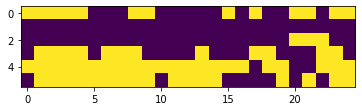

In [36]:
import matplotlib.pyplot as plt

plt.imshow(pd.concat(p, axis=1) > 0.05)

In [19]:
tvalues[0]

Intercept   -0.837533
market       7.503858
factor0      2.433310
factor1     -2.265574
factor2     -0.020642
factor3      2.051476
dtype: float64

In [18]:
r

[0.4287125217765224,
 0.8193757213906077,
 0.8240069052527597,
 0.7998145105316898,
 0.8049122602523822,
 0.7856719527250247,
 0.8836335850899524,
 0.8765219138631805,
 0.8760173428347923,
 0.8405456509470416,
 0.7808616759363703,
 0.8749798515934188,
 0.8970461044608347,
 0.8352951610782254,
 0.8252611345839159,
 0.7675579234752812,
 0.7990441218151142,
 0.7964650854907578,
 0.8102753481228886,
 0.7958790087496989,
 0.7455222633617822,
 0.7070539824822795,
 0.802625252574964,
 0.7921032551599314,
 0.8817394162921868]

# Performance & Robustness Check

In [ ]:
Market_cap = get_market_cap_for_period('20101231', '20191231')

equity = get_item_for_period('ifrs_Equity', '20101231', '20191231')

BEME = equity/Market_cap[0]

In [117]:
Market_cap = get_market_cap_for_period('20110630', '20200630')

In [119]:
Market_cap[0]

,20110630,20120630,20130630,20140630,20150630,20160630,20170630,20180630,20190630,20200630
069110,4.524420e+10,3.366384e+10,7.352183e+10,1.118021e+11,6.659821e+11,2.936650e+11,2.116614e+11,2.371221e+11,1.488294e+11,9.741221e+10
060310,1.503018e+11,6.811222e+11,2.514874e+11,1.778814e+11,1.036619e+11,1.500582e+11,9.738000e+10,1.267502e+11,1.184223e+11,1.084221e+11
900010,6.781855e+10,4.749005e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
038120,6.199044e+10,2.899643e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
013340,4.124653e+10,3.696684e+10,2.788239e+10,2.269956e+10,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
318000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.796565e+10
256150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.901265e+10
272210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.766412e+11
340440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.443550e+09


In [118]:
SMB_mask2 = get_mask(Market_cap[0], Market_cap[1], market_bp ='KOSPI')

SMB2 = get_factor_on_date_by_mask(SMB_mask2, term = 'm', winsorize_limits = 0.01, weight = 'VW')

KeyboardInterrupt: 

In [12]:
# SMB
SMB_mask = get_mask(Market_cap[0], Market_cap[1], breakpoint = [(i+1)/10 for i in range(9)])

SMB = get_factor_on_date_by_mask(SMB_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

<AxesSubplot:>

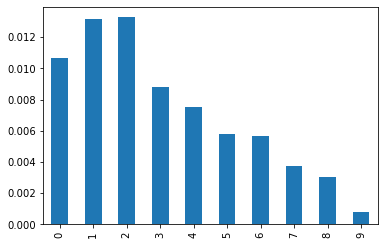

In [20]:
SMB.mean().plot.bar()

In [26]:
import scipy.stats

scipy.stats.ttest_ind(SMB2.iloc[:,0], SMB2.iloc[:,1])

Ttest_indResult(statistic=1.2150159583589863, pvalue=0.22556399828977589)

In [30]:
SMB2

,0,1
201107,0.087574,0.019959
201108,-0.084365,-0.098669
201109,-0.108543,-0.066851
201110,0.094679,0.060636
201111,0.000250,-0.031796
...,...,...
202102,0.011559,0.003117
202103,0.068772,0.019537
202104,0.059620,0.010606
202105,0.019163,0.014820


In [21]:
t1 = get_market_return_for_period('20010101', '20010104')

In [22]:
t2 = get_market_return_for_period('20050101', '20050104')

# BAB Factor Replication

업데이트 요망  
log return overlap할때 가운데 날짜가 들어가는건지? 아니면 앞에 날짜가 들어가는건지? 사실 그리 큰 상관은 없긴 함.  

알고리즘 구성  
log return 구한 후에, 매 6월마다 종목 선정. 750개 이전이 있으면 체크해서 전부 구함. 

In [97]:
stop = False
flag = find_next_market_date('20000101')
price = []
ind = []
market_ret = []
while not stop:
    end = find_next_market_date(find_next_market_date(find_next_market_date(flag)))
    t = get_market_return_for_period(flag, end)
    price.append(t['등락률'])
    market_ret.append((t['등락률'] * t['시가총액'] / t['시가총액'].sum()).sum())
    flag = find_next_market_date(flag)
    ind.append(flag)
    if flag[6:]=='01':
        print(flag)
    if len(price) == 5338:
        stop = True

20000201
20000601
20000801
20000901
20001101
20001201
20010201
20010601
20010801
20011101
20020201
20020401
20020801
20021001
20021101
20030401
20030701
20030801
20030901
20031001
20031201
20040401
20040601
20040701
20040901
20041001
20041101
20041201
20050201
20050401
20050601
20050701
20050801
20050901
20051101
20051201
20060201
20060601
20060801
20060901
20061101
20061201
20070201
20070601
20070801
20071001
20071101
20080201
20080401
20080701
20080801
20080901
20081001
20081201
20090401
20090601
20090701
20090901
20091001
20091201
20100201
20100401
20100601
20100701
20100901
20101001
20101101
20101201
20110201
20110401
20110601
20110701
20110801
20110901
20111101
20111201
20120201
20120601
20120801
20121101
20130201
20130401
20130701
20130801
20131001
20131101
20140401
20140701
20140801
20140901
20141001
20141201
20150401
20150601
20150701
20150901
20151001
20151201
20160201
20160401
20160601
20160701
20160801
20160901
20161101
20161201
20170201
20170601
20170801
20170901
20171101
2

In [98]:
with open('price.pkl', 'wb') as f:
    pickle.dump(price, f)
with open('price.pkl', 'rb') as f:
    price = pickle.load(f)

In [99]:
log_return = pd.concat(price, axis=1)
log_return.columns = ind

In [100]:
log_return = log_return.applymap(lambda x: np.log(1+float(x)))

<ipython-input-100-cae439bab00a>:1: RuntimeWarning: divide by zero encountered in log
  log_return = log_return.applymap(lambda x: np.log(1+float(x)))


In [101]:
# 기준 날짜 설정 (6월 마지막 거래일)
stand = []
for i in range(log_return.shape[1]-1):
    if log_return.columns[i][4:6]=='06' and log_return.columns[i+1][4:6]=='07':
        stand.append(i)

In [102]:
df = pd.concat([log_return, pd.DataFrame(market_ret, index = log_return.columns, columns = ['market']).T])

In [103]:
corr = []
for i in tqdm.tqdm(range(len(stand)-5)):
    corr.append(df.iloc[:,stand[i]:stand[i+5]].T.corr(min_periods=750).iloc[-1] * (df.iloc[:,stand[i+5]] / df.iloc[:,stand[i+5]]))
    # 뒤의 파트는 해당 시점에 거래되고 있었는지를 체크하기 위한 것.
corr = pd.concat(corr, axis=1)

In [115]:
var = []
bab_ind = []
for i in tqdm.tqdm(range(len(stand)-5)):
    var.append(df.iloc[:,stand[i+4]:stand[i+5]].T.var() * ((df.iloc[:,stand[i+5]]+100) / (df.iloc[:,stand[i+5]]+100)) * ((df.iloc[:,stand[i+5]-120]+100) / (df.iloc[:,stand[i+5]-120]+100)))
    bab_ind.append(df.columns[stand[i+5]])
    # 뒤의 파트는 해당 시점에 거래되고 있었는지를 체크하기 위한 것.
var = pd.concat(var, axis=1)

In [105]:
std = var.applymap(lambda x: np.sqrt(x))

In [106]:
beta = std / std.iloc[-1,:] * corr

In [134]:
# beta 구하기 성공

In [107]:
# beta shrinkage
beta_sh = beta.applymap(lambda x: 0.6*x + 0.4)

In [108]:
beta_sh = beta_sh.iloc[:-1]

In [118]:
beta_sh.columns = bab_ind

In [19]:
k = 2/(beta_sh.rank() - beta_sh.rank().mean()).abs().sum()

w_h = k * ((beta_sh.rank() - beta_sh.rank().mean() > 0) * (beta_sh.rank() - beta_sh.rank().mean()))

w_l = - k * ((beta_sh.rank() - beta_sh.rank().mean() < 0) * (beta_sh.rank() - beta_sh.rank().mean()))

beta_l = (w_l * beta).sum()

beta_h = (w_h * beta).sum()

In [24]:
see = np.array([x-x%3 for x in stand])

r_t = []
for i in range(len(see)-6):
    r_t.append(df.values[:,::3].cumsum(axis=1)[:,int(see[i+6]/3)]- df.values[:,::3].cumsum(axis=1)[:,int(see[i+5]/3)])

r_t = pd.DataFrame(r_t, columns = df.index).T
r_t = r_t.iloc[:-1]

r_l = (r_t * w_l.iloc[:,:-1]).sum()

r_h = (r_t * w_h.iloc[:,:-1]).sum()

In [25]:
bab = (r_l - 0.02) / beta_l - (r_h-0.02)/beta_h

In [26]:
bab

0     0.256508
1     0.386428
2    -0.225077
3    -0.633780
4    -0.055048
5    -0.045190
6    -0.018484
7     0.140403
8     0.111276
9     0.266354
10   -0.055876
11   -0.053328
12   -0.106793
13   -0.452346
14   -0.222263
15    0.297469
16         NaN
dtype: float64

In [93]:
r_l > r_h

0      True
1      True
2      True
3     False
4      True
5     False
6      True
7      True
8      True
9      True
10     True
11    False
12    False
13    False
14     True
15     True
dtype: bool

# Quality Factor Replication

Profitability = gpoa + roe + roa + cfoa + gmar + acc  
gpoa = GP / AT  
roe = PL / BE  
roa = PL / AT  
cfoa = FCF / AT = (CFO - PNE_change)/AT = (CFO - CAPEX)/AT (출처: 네이버 금융)  
gmar = GP / REV
acc = -(WC_change - DP)/AT = -((STR+INV-STP)_change - DP)/AT

Growth = gpoa_change + roe_change + roa_change + cfoa_change + gmar_change  
-> 수정주식수로 나누어줘야 하는데, 이걸 어떻게 처리해야 할지 모르겠네...  


In [10]:
GP = get_item_for_period('ifrs_GrossProfit', '20121231', '20201231')
AT = get_item_for_period('ifrs_Assets', '20121231', '20201231')
BE = get_item_for_period('ifrs_Equity', '20121231', '20201231')
DEBT = get_item_for_period('ifrs_Liabilities', '20121231', '20201231')
PL = get_item_for_period('ifrs_ProfitLoss', '20121231', '20201231')
PNE = get_item_for_period('ifrs_PropertyPlantAndEquipment', '20121231', '20201231')
CFO = get_item_for_period('ifrs_CashFlowsFromUsedInOperatingActivities', '20121231', '20201231')
REV = get_item_for_period('ifrs_Revenue', '20121231', '20201231')
DP = get_item_for_period('dart_DepreciationExpense', '20121231', '20201231')
STR = get_item_for_period('dart_ShortTermTradeReceivable', '20121231', '20201231')
STR_2 = get_item_for_period('ifrs_TradeAndOtherCurrentReceivables', '20121231', '20201231')
INV = get_item_for_period('ifrs_Inventories', '20121231', '20201231')
STP = get_item_for_period('dart_ShortTermTradePayables', '20121231', '20201231')
STP_2 = get_item_for_period('ifrs_TradeAndOtherCurrentPayables', '20121231', '20201231')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
C:\Users\lyoo9\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
DP_2 = get_item_for_period('dart_AdjustmentsForDepreciationExpense', '20121231', '20201231')

In [12]:
gpoa = ((GP/AT).rank() - (GP / AT).rank().mean())/(GP/AT).rank().std()
roe = ((PL/BE).rank() - (PL/BE).rank().mean())/(PL/BE).rank().std()
roa = ((PL/AT).rank() - (PL/AT).rank().mean())/(PL/AT).rank().std()
cfoa = (((CFO - (PNE.T - PNE.T.shift(1)).T)/AT).rank() - ((CFO - (PNE.T - PNE.T.shift(1)).T)/AT).rank().mean())/((CFO - (PNE.T - PNE.T.shift(1)).T)/AT).rank().std()
gmar = ((GP/REV).rank() - (GP/REV).rank().mean())/(GP/REV).rank().std()

STR_T = pd.concat([STR, STR_2], axis = 1).groupby(level=0, axis=1).first()
STP_T = pd.concat([STP, STP_2], axis = 1).groupby(level=0, axis=1).first()
WC_change = ((STR_T + INV - STP_T).T - (STR_T + INV - STP_T).T.shift(1)).T
DP_T = t = pd.DataFrame(0, index = WC_change.index, columns = WC_change.columns)
DP_T.loc[list(set(DP_2.index ) & set(WC_change.index)), DP_2.columns] = DP_2.loc[list(set(DP_2.index) & set(WC_change.index)),:].values
acc = ((-(WC_change - DP_T)/AT).rank() - (-(WC_change - DP_T)/AT).rank().mean())/(-(WC_change - DP_T)/AT).rank().std()

In [13]:
P_raw = gpoa + roe + roa + cfoa + gmar + acc
P_score = (P_raw.rank() - P_raw.rank().mean())/P_raw.rank().std()

In [43]:
P_mask = get_mask(P_score, get_market_category(P_score), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])
P_factor = get_factor_on_date_by_mask2(P_mask.iloc[:,1:], term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
P_factor.mean()

0    0.000285
1    0.001627
2    0.002047
dtype: float64

## Growth

In [61]:
from scipy import stats

In [32]:
def transform_z(data):
    return (data.rank() - data.rank().mean())/data.rank().std()

In [34]:
d_gpoa = transform_z(GP/AT - (GP/AT).T.shift(5).T)
d_roe = transform_z(PL/BE - (PL/BE).T.shift(5).T)
d_roa = transform_z(PL/AT - (PL/AT).T.shift(5).T)
d_cfoa = transform_z(((CFO - (PNE.T - PNE.T.shift(1)).T)/AT) - ((CFO - (PNE.T - PNE.T.shift(1)).T)/AT).T.shift(5).T)
d_gmar = transform_z(GP/REV - (GP/REV).T.shift(5).T)

In [35]:
G_raw = d_gpoa + d_roe + d_roa + d_cfoa + d_gmar

In [40]:
G_score = transform_z(G_raw.iloc[:,-3:])

In [44]:
G_mask = get_mask(G_score, get_market_category(G_score), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])
G_factor = get_factor_on_date_by_mask2(G_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [46]:
G_factor.mean()

0    0.002482
1    0.007044
2    0.009441
dtype: float64

In [71]:
stats.ttest_1samp(G_factor.iloc[:,2], 0)

Ttest_1sampResult(statistic=0.9877405796616928, pvalue=0.33144975144781497)

## Safety

In [ ]:
lev = -transform_z(DEBT/BE)

evol = -transform_z((PL/BE).rolling(5).std().iloc[:,5:])
bab_safety = -transform_z(beta_sh.iloc[:,12:16])

bab_safety.columns = lev.columns[5:]

In [158]:
# altman z-score
WC = STR_T + INV - STP_T
RE = get_item_for_period('ifrs_RetainedEarnings', '20121231', '20201231')
# altman_z = 

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
C:\Users\lyoo9\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [162]:
RE

,20121231,20131231,20141231,20151231,20161231,20171231,20181231,20191231,20201231
corp_code,,,,,,,,,
0,NaN,9.174183e+09,3.824892e+08,-1.255830e+10,-9.631245e+09,5.726453e+09,1.221648e+10,1.864302e+10,2.138170e+10
0,1.496624e+11,1.710472e+11,1.946992e+11,2.200558e+11,2.461470e+11,2.735007e+11,2.968882e+11,3.164564e+11,NaN
0,5.509698e+10,5.617982e+10,NaN,NaN,NaN,NaN,6.560183e+10,6.395732e+10,5.642970e+10
0,4.395180e+10,5.864348e+10,8.021218e+10,8.658887e+10,8.539205e+10,9.708067e+10,1.031438e+11,1.082249e+11,NaN
0,4.956368e+11,5.112534e+11,5.416453e+11,5.689783e+11,5.922439e+11,6.401730e+11,6.886999e+11,6.998749e+11,7.206361e+11
...,...,...,...,...,...,...,...,...,...
1,4.298559e+12,4.840682e+12,4.872463e+12,3.593524e+12,3.519571e+12,3.198433e+12,2.800081e+12,1.502204e+12,3.008527e+10
1,1.951647e+10,2.913010e+10,3.839561e+10,4.502772e+10,2.944346e+10,3.187266e+10,4.343728e+10,6.964641e+10,5.644525e+11
1,NaN,NaN,NaN,1.874512e+10,2.471432e+10,2.602897e+10,2.550687e+10,2.816136e+10,2.328300e+10


In [134]:
S_raw = lev + evol + bab_safety
S_score = transform_z(S_raw)

S_score = S_score.loc[lev.index]

In [151]:
S_mask = get_mask(S_score.iloc[:,5:], get_market_category(S_score.iloc[:,5:]), market_bp = 'KOSPI', breakpoint = [0.3, 0.7])
S_factor = get_factor_on_date_by_mask2(S_mask, term = 'm', winsorize_limits = 0.01, weight = 'VW')

C:\Users\lyoo9\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [152]:
S_factor.mean()

0    0.001848
1    0.001884
2    0.000881
dtype: float64